In [88]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [89]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])

In [90]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [91]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [118]:
class autoencoder(nn.Module):
    input_size = 784
    hidden_sizes = [128, 32]
    output_size = 10
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(self.input_size, self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.output_size))
        self.decoder = nn.Sequential(nn.Linear(self.output_size, self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.input_size),
                      nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = autoencoder()
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)


In [119]:

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities

criterion = nn.MSELoss()

#tlabls = labelTransform(labels,10)
loss = criterion(logps,images) #calculate the loss


In [120]:
print('Before backward pass: \n', model.encoder[0].weight.grad)
loss.backward()
print('After backward pass: \n', model.encoder[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-7.3549e-06, -7.3549e-06, -7.3549e-06,  ..., -7.3549e-06,
         -7.3549e-06, -7.3549e-06],
        [-9.8367e-05, -9.8367e-05, -9.8367e-05,  ..., -9.8367e-05,
         -9.8367e-05, -9.8367e-05],
        [-2.1317e-05, -2.1317e-05, -2.1317e-05,  ..., -2.1317e-05,
         -2.1317e-05, -2.1317e-05],
        ...,
        [ 1.2896e-07,  1.2896e-07,  1.2896e-07,  ...,  1.2896e-07,
          1.2896e-07,  1.2896e-07],
        [ 4.2754e-05,  4.2754e-05,  4.2754e-05,  ...,  4.2754e-05,
          4.2754e-05,  4.2754e-05],
        [ 1.0478e-05,  1.0478e-05,  1.0478e-05,  ...,  1.0478e-05,
          1.0478e-05,  1.0478e-05]])


In [123]:
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)
time0 = time()
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        
        output = model(images)
        loss = criterion(output, images)
        
        #This is where the model learns by backpropagating
        optimizer.zero_grad()
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.08282155976461958
Epoch 1 - Training loss: 0.07876461332858499
Epoch 2 - Training loss: 0.07650493115567958
Epoch 3 - Training loss: 0.07509521623727863
Epoch 4 - Training loss: 0.07400383241077475


KeyboardInterrupt: 

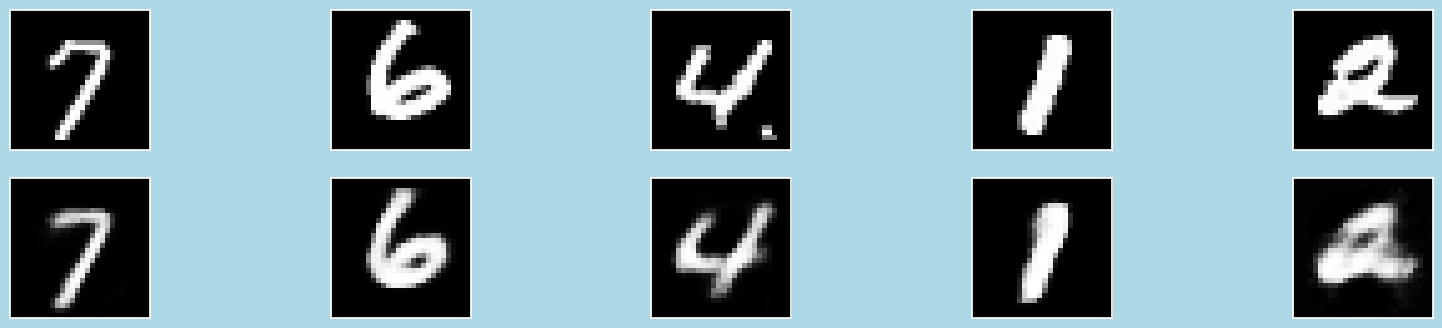

In [147]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model.encoder(images.view(-1, 784))
    decoded = model.decoder(logps)

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()